In [1]:
pip install shifterator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 MB 8.6 MB/s eta 0:00:00


In [2]:
import os
import re
import nltk
import string
import unicodedata
from collections import Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams



In [ ]:
# pip install matplotlib==3.3.4  # downgrading matplotlib to tackle the shifterator error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
pre_folder = '/content/drive/MyDrive/TFG/PRE_ELEC_SCRIPTS'
pre_files = [os.path.join(pre_folder, f) for f in os.listdir(pre_folder) if f.endswith(".txt")]

post_folder = '/content/drive/MyDrive/TFG/POST_ELEC_SCRIPTS'
post_files = [os.path.join(post_folder, f) for f in os.listdir(post_folder) if f.endswith(".txt")]


In [5]:
nltk.download("stopwords")
nltk.download("punkt_tab")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [6]:
# Aux functions

stop_words = set(stopwords.words('english'))

def plain_texter(text):
  text = re.sub(r"\s+", " ", text)
  text = text.lower()
  return ''.join(ch for ch in text if not unicodedata.category(ch).startswith(('P', 'S')))

def my_tokenizer(text):
  tokens = word_tokenize(text)
  tokens = [word for word in tokens if word not in stop_words]
  return tokens

In [7]:
# function to read and process each file

def preproc(file_list):
  all_tokens = []
  doc_lens = []

  for file in file_list:
    with open(file, 'r', encoding='utf-8') as f:
      text = f.read()
      text = plain_texter(text)
      tokens = my_tokenizer(text)
      doc_lens.append(len(tokens))
      all_tokens.extend(tokens)
  return all_tokens, doc_lens


# function to get uni and bi-grams
def ngram_freqs(tokens, n=1):
  if n==1:
    return Counter(tokens)
  else:
    bigrams = ngrams(tokens, n)
    bi_strings = [' '.join(bigram) for bigram in bigrams]
    return Counter(bi_strings)

In [30]:
pre_tokens, pre_lens = preproc(pre_files)
post_tokens, post_lens = preproc(post_files)



In [31]:
time_zones = ['pm', 'est', 'edt', 'cst', 'am', 'pst', 'mst']

pre_clean = [t for t in pre_tokens if t not in time_zones]
post_clean = [t for t in post_tokens if t not in time_zones]

### Shifts

In [32]:

pre_uni = ngram_freqs(pre_clean, 1)
post_uni = ngram_freqs(post_clean, 1)

pre_bi = ngram_freqs(pre_clean, 2)
post_bi = ngram_freqs(post_clean, 2)

pre_comb = pre_uni+pre_bi
post_comb = post_uni+post_bi

unigrams


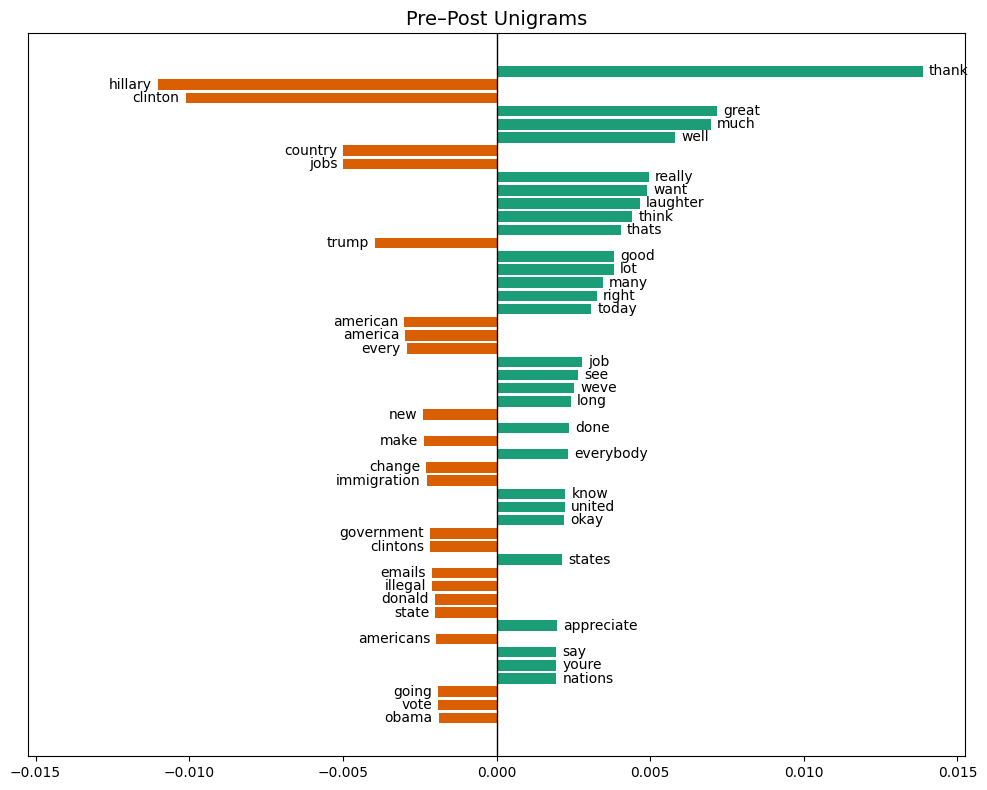

In [34]:
import pandas as pd
import matplotlib.pyplot as plt
from shifterator import shifts as rs

# Create shift object and get scores
shift = rs.ProportionShift(type2freq_1=pre_uni, type2freq_2=post_uni)
shift_scores = shift.get_shift_scores()
shift_df = pd.DataFrame(shift_scores.items(), columns=["word", "shift_score"])

# Select top N by absolute contribution
top_n = 50
shift_df = shift_df.reindex(shift_df['shift_score'].abs().sort_values(ascending=False).index)
shift_df = shift_df.head(top_n)
shift_df = shift_df[::-1].reset_index(drop=True)  # flip for plot order

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#d95f02' if x < 0 else '#1b9e77' for x in shift_df['shift_score']]
bars = ax.barh(shift_df.index, shift_df['shift_score'], color=colors)

# Annotate each bar at its endpoint
for i, (score, word) in enumerate(zip(shift_df['shift_score'], shift_df['word'])):
    if score < 0:
        ax.text(score - 0.0002, i, word, va='center', ha='right', fontsize=10)
    else:
        ax.text(score + 0.0002, i, word, va='center', ha='left', fontsize=10)

# Draw a fixed center line
ax.axvline(0, color='black', linewidth=1)

# Set symmetric x-axis limits to keep center line fixed
max_val = shift_df['shift_score'].abs().max()
ax.set_xlim(-max_val * 1.1, max_val * 1.1)  # Add 10% padding

# Clean up plot
ax.set_yticks([])
ax.set_title("Pre–Post Unigrams", fontsize=14)
# ax.set_xlabel("Contribution to Shift", fontsize=12)

plt.tight_layout()
plt.show()


bigrams

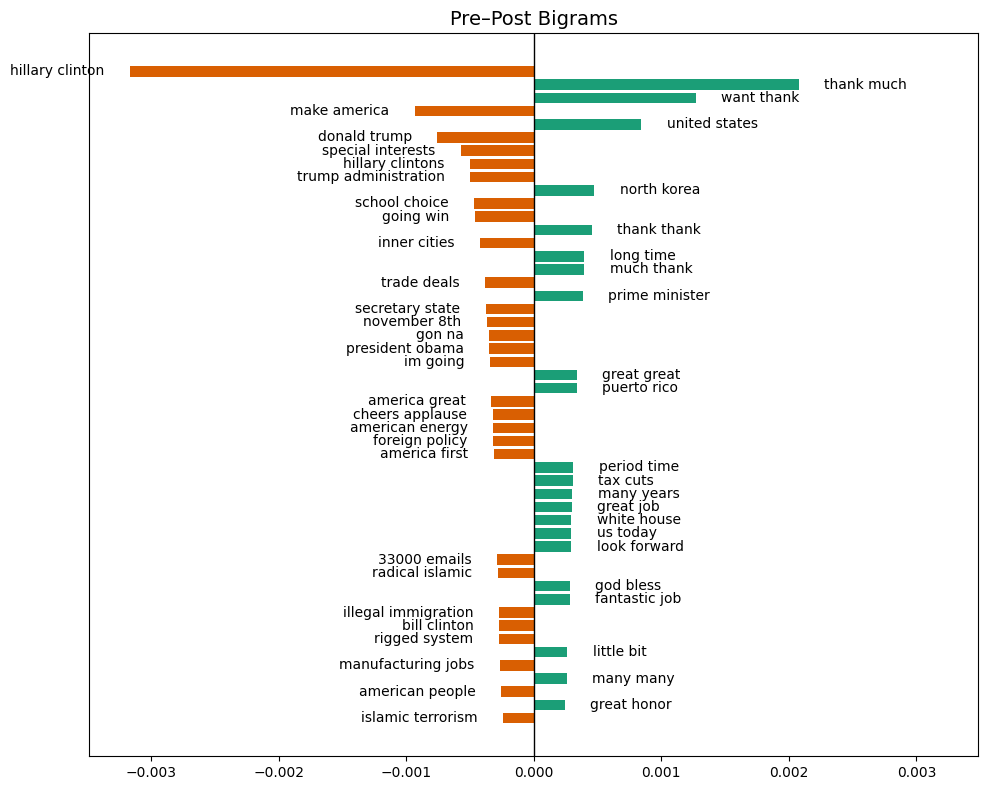

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
from shifterator import shifts as rs

# Create shift object and get scores
shift = rs.ProportionShift(type2freq_1=pre_bi, type2freq_2=post_bi)
shift_scores = shift.get_shift_scores()
shift_df = pd.DataFrame(shift_scores.items(), columns=["word", "shift_score"])

# Select top N by absolute contribution
top_n = 50
shift_df = shift_df.reindex(shift_df['shift_score'].abs().sort_values(ascending=False).index)
shift_df = shift_df.head(top_n)
shift_df = shift_df[::-1].reset_index(drop=True)  # flip for plot order

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#d95f02' if x < 0 else '#1b9e77' for x in shift_df['shift_score']]
bars = ax.barh(shift_df.index, shift_df['shift_score'], color=colors)

# Annotate each bar at its endpoint
for i, (score, word) in enumerate(zip(shift_df['shift_score'], shift_df['word'])):
    if score < 0:
        ax.text(score - 0.0002, i, word, va='center', ha='right', fontsize=10)
    else:
        ax.text(score + 0.0002, i, word, va='center', ha='left', fontsize=10)

# Draw a fixed center line
ax.axvline(0, color='black', linewidth=1)

# Set symmetric x-axis limits to keep center line fixed
max_val = shift_df['shift_score'].abs().max()
ax.set_xlim(-max_val * 1.1, max_val * 1.1)  # Add 10% padding

# Clean up plot
ax.set_yticks([])
ax.set_title("Pre–Post Bigrams", fontsize=14)
# ax.set_xlabel("Contribution to Shift", fontsize=12)

plt.tight_layout()
plt.show()


uni+bigrams

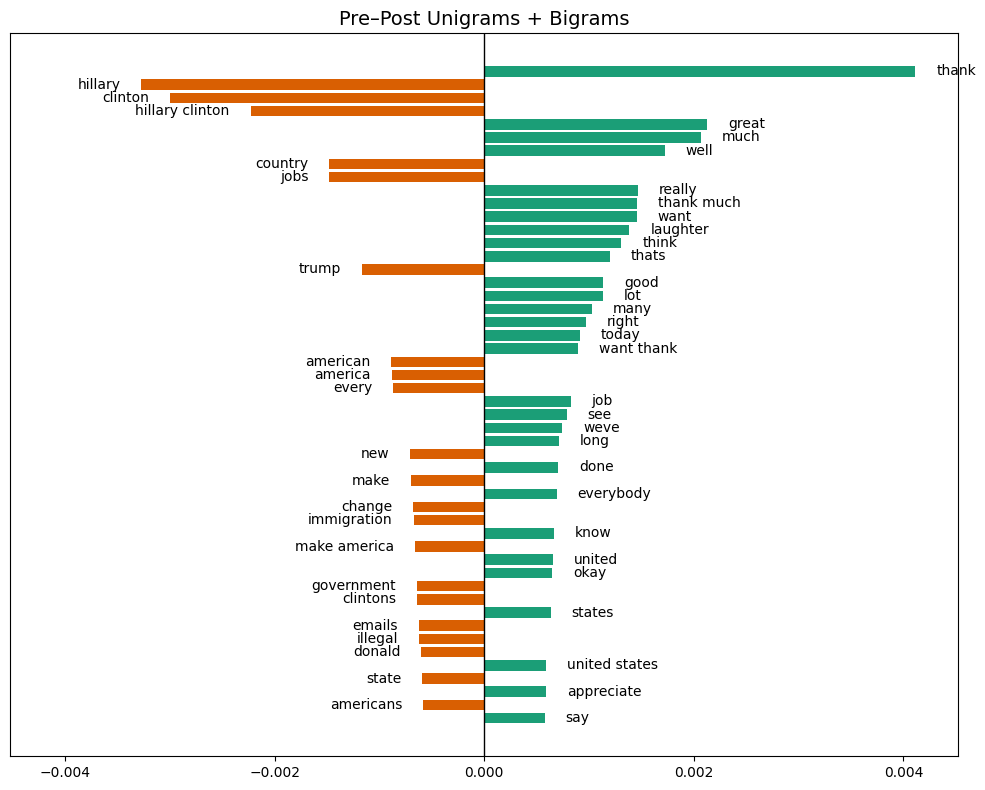

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from shifterator import shifts as rs

# Create shift object and get scores
shift = rs.ProportionShift(type2freq_1=pre_comb, type2freq_2=post_comb)
shift_scores = shift.get_shift_scores()
shift_df = pd.DataFrame(shift_scores.items(), columns=["word", "shift_score"])

# Select top N by absolute contribution
top_n = 50
shift_df = shift_df.reindex(shift_df['shift_score'].abs().sort_values(ascending=False).index)
shift_df = shift_df.head(top_n)
shift_df = shift_df[::-1].reset_index(drop=True)  # flip for plot order

# Create figure
fig, ax = plt.subplots(figsize=(10, 8))
colors = ['#d95f02' if x < 0 else '#1b9e77' for x in shift_df['shift_score']]
bars = ax.barh(shift_df.index, shift_df['shift_score'], color=colors)

# Annotate each bar at its endpoint
for i, (score, word) in enumerate(zip(shift_df['shift_score'], shift_df['word'])):
    if score < 0:
        ax.text(score - 0.0002, i, word, va='center', ha='right', fontsize=10)
    else:
        ax.text(score + 0.0002, i, word, va='center', ha='left', fontsize=10)

# Draw a fixed center line
ax.axvline(0, color='black', linewidth=1)

# Set symmetric x-axis limits to keep center line fixed
max_val = shift_df['shift_score'].abs().max()
ax.set_xlim(-max_val * 1.1, max_val * 1.1)  # Add 10% padding

# Clean up plot
ax.set_yticks([])
ax.set_title("Pre–Post Unigrams + Bigrams", fontsize=14)
# ax.set_xlabel("Contribution to Shift", fontsize=12)

plt.tight_layout()
plt.show()


### Key Statistics

In [ ]:
import statistics as sts

# print(sts.mean(pre_lens))

pre_unique = set(pre_tokens)
post_unique = set(post_tokens)

print(len(pre_unique))
print(len(post_unique))

8736
10192


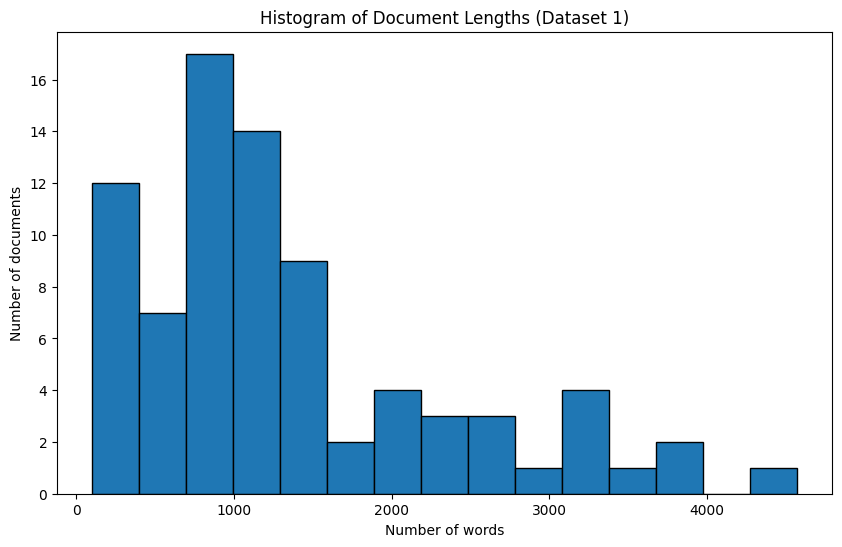

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
plt.hist(pre_lens, bins=15, edgecolor='black')
plt.title("Histogram of Document Lengths (Dataset 1)")
plt.xlabel("Number of words")
plt.ylabel("Number of documents")
plt.show()

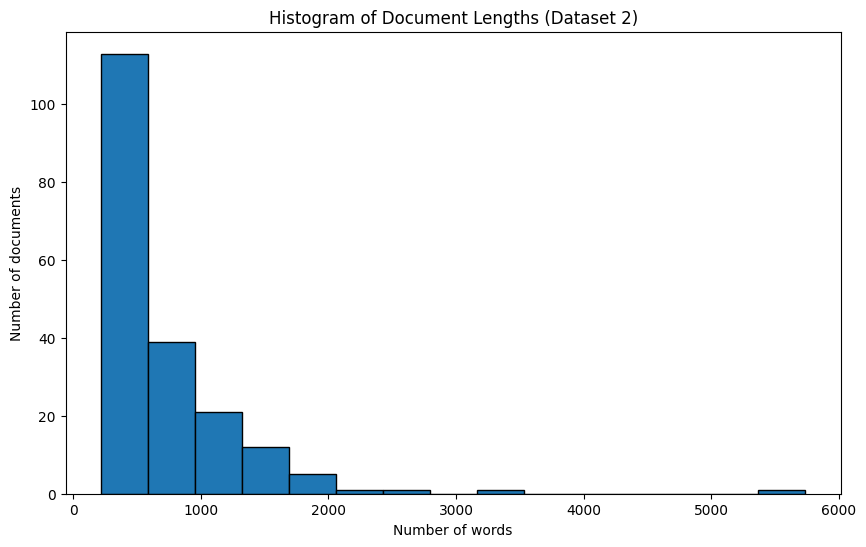

In [ ]:
plt.figure(figsize=(10,6))
plt.hist(post_lens, bins=15, edgecolor='black')
plt.title("Histogram of Document Lengths (Dataset 2)")
plt.xlabel("Number of words")
plt.ylabel("Number of documents")
plt.show()

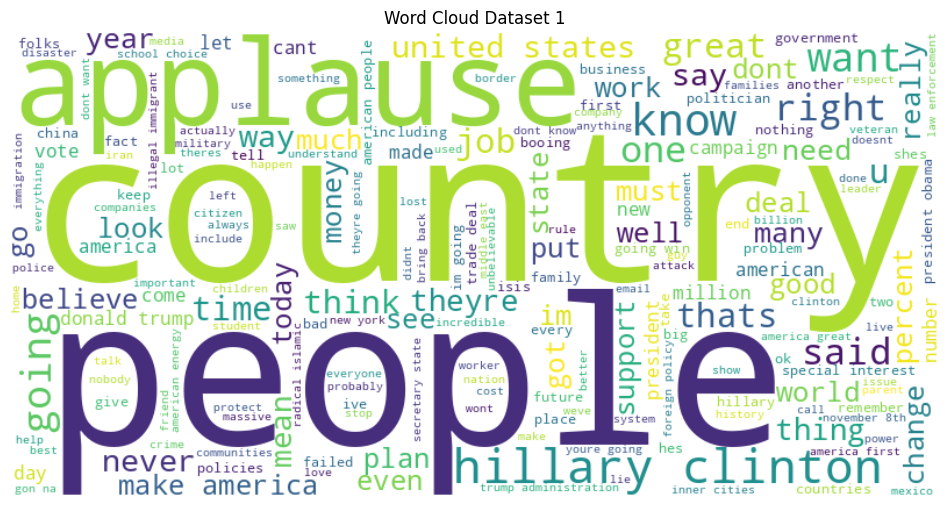

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

pre_str = ' '.join(pre_tokens)
pre_wc = WordCloud(width=800, height=400, background_color='white').generate(pre_str)

plt.figure(figsize=(12, 8))
plt.imshow(pre_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud Dataset 1")
plt.show()

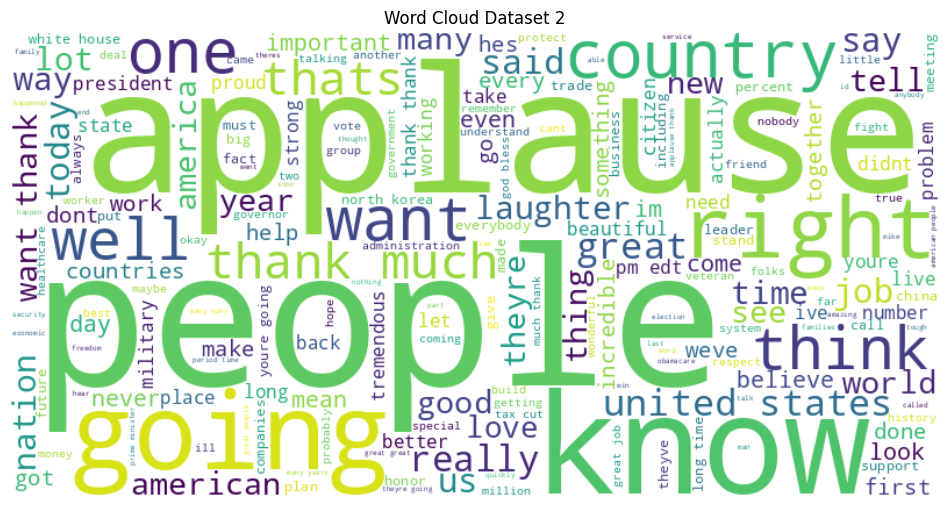

In [ ]:
post_str = ' '.join(post_tokens)
post_wc = WordCloud(width=800, height=400, background_color='white').generate(post_str)

plt.figure(figsize=(12, 8))
plt.imshow(post_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud Dataset 2")
plt.show()

## EXTRA

In [ ]:
pre_col = preproc(pre_files)
post_col = preproc(post_files)

In [ ]:
pre_tokens = [word for text in pre_col for word in text]
pre_freq = Counter(pre_tokens)

post_tokens = [word for text in post_col for word in text]
post_freq = Counter(post_tokens)

AttributeError: 'YTick' object has no attribute 'label'

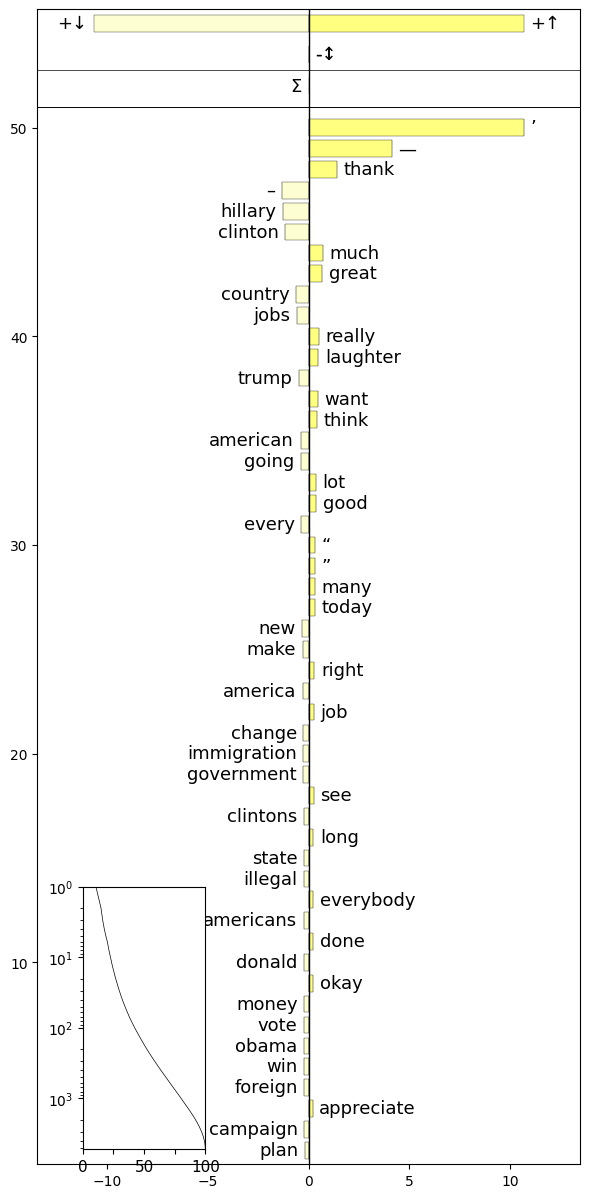

In [ ]:
freq_shift = sh.WeightedAvgShift(type2freq_1 = pre_freq, type2freq_2 = post_freq, handle_missing_scores="exclude")
freq_shift.get_shift_graph(system_names = ['PreElec', 'PostElec'])
